<a href="https://colab.research.google.com/github/galiveetiprakash/AIML/blob/master/NY_JOBS_NLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Code for Step 1
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
listed = drive.ListFile({'q': "title contains 'nyc_job.zip' and '1eJpQaJ8pwwqpCgdA6spl3dCANpB5MUYV' in parents"}).GetList()

for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title nyc_job.zip, id 1G2h2yFvG5vPvjwMuFpiUZwbMn11HxcMZ


In [0]:
train_downloaded = drive.CreateFile({'id': '1G2h2yFvG5vPvjwMuFpiUZwbMn11HxcMZ'})
train_downloaded.GetContentFile('nyc_job.zip')

In [0]:
import zipfile
import pandas as pd
import numpy as np
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from collections import Counterw
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud,STOPWORDS

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
with zipfile.ZipFile("nyc_job.zip") as zip_ref:
  zip_ref.extractall()

In [0]:
#Define the colors
p = "YlGnBu"
p2 = "YlGn"
p3 = "Greys"

In [0]:
jobs = pd.read_csv("nyc-jobs.csv")
jobs.head(3)

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,Salary Range From,Salary Range To,Salary Frequency,Work Location,Division/Work Unit,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,NaN,NaN,42405.00,65485.00,Annual,110 William St. N Y,Strategy & Analytics,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â€¢\tExcellent interpersonal and organizationa...,"Salary range for this position is: $42,405 - $...",NaN,NaN,NaN,NaN,New York City residency is generally required ...,2011-06-24T00:00:00.000,NaN,2011-06-24T00:00:00.000,2019-06-11T00:00:00.000
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,NaN,F,60740.00,162014.00,Annual,110 William St. N Y,Tech Talent Pipeline,The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,NaN,NaN,"In addition to applying through this website, ...",NaN,NaN,NaN,New York City residency is generally required ...,2012-01-26T00:00:00.000,NaN,2012-01-26T00:00:00.000,2019-06-11T00:00:00.000
2,132292,NYC HOUSING AUTHORITY,External,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,51907.68,54580.32,Annual,Heating Mgt-Operations,Management Services Department,"Under direct supervision, assist in the routin...",1. Three years of full-time satisfactory exper...,1. A High School Diploma or GED. 2. CDL Dri...,1. A Motor Vehicle Driverâ€™s License valid i...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-06-11T00:00:00.000


In [0]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 28 columns):
Job ID                           3159 non-null int64
Agency                           3159 non-null object
Posting Type                     3159 non-null object
# Of Positions                   3159 non-null int64
Business Title                   3159 non-null object
Civil Service Title              3159 non-null object
Title Code No                    3159 non-null object
Level                            3159 non-null object
Job Category                     3157 non-null object
Full-Time/Part-Time indicator    2926 non-null object
Salary Range From                3159 non-null float64
Salary Range To                  3159 non-null float64
Salary Frequency                 3159 non-null object
Work Location                    3159 non-null object
Division/Work Unit               3159 non-null object
Job Description                  3159 non-null object
Minimum Qual Requirements    

Data cleaning & Feature engineering

In [0]:
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color='white',
                     width=1024, height=720).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
def parse_categories(x):
    l = x.replace('&', ',').split(',')
    print(l)
    l = [x.strip().rstrip(',') for x in l]
    print(l)
    key_categories.extend(l)

def parse_keywords(x, l):
    x = x.lower()
    tokens = nltk.word_tokenize(x)
    stop_words = set(stopwords.words('english'))
    token_l = [w for w in tokens if not w in stop_words and w.isalpha()]
    l.extend(token_l)
    
def preferred_skills(x):
    kwl = []
    jobs[jobs.job_category==x].preferred_skills.dropna().apply(parse_keywords, l=kwl)
    kwl = pd.Series(kwl)
    return kwl.value_counts()[:20]

In [0]:
jobs.columns

Index(['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title',
       'Civil Service Title', 'Title Code No', 'Level', 'Job Category',
       'Full-Time/Part-Time indicator', 'Salary Range From', 'Salary Range To',
       'Salary Frequency', 'Work Location', 'Division/Work Unit',
       'Job Description', 'Minimum Qual Requirements', 'Preferred Skills',
       'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1',
       'Recruitment Contact', 'Residency Requirement', 'Posting Date',
       'Post Until', 'Posting Updated', 'Process Date'],
      dtype='object')

In [0]:
#Drop the Recuitment Contact and Post Until Columns
jobs.drop(['Recruitment Contact', 'Post Until'], axis=1, inplace=True)

In [0]:
#Define the Column names
jobs.columns = ['id', 'agency', 'posting_type', 'number_of_positions', 'business_title', 'civil_service_title', 'title_code_number', 'level', 'job_category', 'full-time/part-time', 'salary_range_low', 'salary_range_high', 'salary_frequency', 'work_location', 'work_unit', 'job_description', 'minimum_requirements', 'preferred_skills', 'additional_info', 'to_apply', 'shift', 'work_location_1', 'residency_requirement', 'posting_date', 'posting_updated', 'process_date' ]

In [0]:
#Verify the column names
jobs.columns

Index(['id', 'agency', 'posting_type', 'number_of_positions', 'business_title',
       'civil_service_title', 'title_code_number', 'level', 'job_category',
       'full-time/part-time', 'salary_range_low', 'salary_range_high',
       'salary_frequency', 'work_location', 'work_unit', 'job_description',
       'minimum_requirements', 'preferred_skills', 'additional_info',
       'to_apply', 'shift', 'work_location_1', 'residency_requirement',
       'posting_date', 'posting_updated', 'process_date'],
      dtype='object')

In [0]:
jobs['job_category'].unique()

array([nan, 'Maintenance & Operations',
       'Finance, Accounting, & Procurement',
       'Health Public Safety, Inspections, & Enforcement',
       'Engineering, Architecture, & Planning',
       'Clerical & Administrative Support',
       'Information Technology & Telecommunications',
       'Finance, Accounting, & Procurement Information Technology & Telecommunications',
       'Community & Business Services',
       'Clerical & Administrative Support Legal',
       'Clerical & Administrative Support Community & Business Services',
       'Social Services',
       'Engineering, Architecture, & Planning Maintenance & Operations',
       'Health', 'Clerical & Administrative Support Policy & Analysis',
       'Community & Business Services Social Services',
       'Public Safety, Inspections, & Enforcement', 'Legal',
       'Policy & Analysis Social Services',
       'Information Technology & Telecommunications Policy & Analysis Social Services',
       'Legal Policy & Analysis',
   

In [0]:
jobs.job_category.value_counts()

Engineering, Architecture, & Planning                                                               537
Technology, Data & Innovation                                                                       320
Public Safety, Inspections, & Enforcement                                                           236
Health                                                                                              216
Legal Affairs                                                                                       182
                                                                                                   ... 
Administration & Human Resources Technology, Data & Innovation Building Operations & Maintenance      1
Administration & Human Resources Communications & Intergovernmental Affairs Legal Affairs             1
Administration & Human Resources Health Public Safety, Inspections, & Enforcement                     1
Administration & Human Resources Finance, Accounting, & Procurem

In [0]:
key_categories = []
jobs.job_category.dropna().apply(parse_categories)
key_categories = pd.Series(key_categories)
key_categories = key_categories[key_categories!='']
print(key_categories)
popular_categories = key_categories.value_counts().iloc[:25]
popular_categories

Streaming output truncated to the last 5000 lines.
['Technology', 'Data', 'Innovation']
['Administration ', ' Human Resources Constituent Services ', ' Community Programs Policy', ' Research ', ' Analysis']
['Administration', 'Human Resources Constituent Services', 'Community Programs Policy', 'Research', 'Analysis']
['Engineering', ' Architecture', ' ', ' Planning']
['Engineering', 'Architecture', '', 'Planning']
['Engineering', ' Architecture', ' ', ' Planning']
['Engineering', 'Architecture', '', 'Planning']
['Technology', ' Data ', ' Innovation']
['Technology', 'Data', 'Innovation']
['Technology', ' Data ', ' Innovation']
['Technology', 'Data', 'Innovation']
['Finance', ' Accounting', ' ', ' Procurement Policy', ' Research ', ' Analysis']
['Finance', 'Accounting', '', 'Procurement Policy', 'Research', 'Analysis']
['Finance', ' Accounting', ' ', ' Procurement Policy', ' Research ', ' Analysis']
['Finance', 'Accounting', '', 'Procurement Policy', 'Research', 'Analysis']
['Technology'

Architecture              771
Engineering               750
Planning                  540
Inspections               502
Enforcement               492
Research                  432
Data                      416
Innovation                383
Analysis                  377
Technology                340
Accounting                295
Administration            269
Constituent Services      240
Public Safety             239
Finance                   239
Health                    216
Maintenance               214
Building Operations       188
Procurement               184
Legal Affairs             182
Community Programs        161
Policy                    141
Human Resources           134
Planning Public Safety     98
Communications             70
dtype: int64

In [0]:
jobs['full-time/part-time'].value_counts()

F    2757
P     169
Name: full-time/part-time, dtype: int64

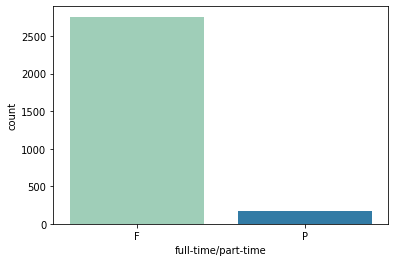

In [0]:
sns.countplot(x='full-time/part-time', data=jobs, palette=p)

In [0]:
jobs.salary_frequency.value_counts()

Annual    2862
Hourly     263
Daily       34
Name: salary_frequency, dtype: int64

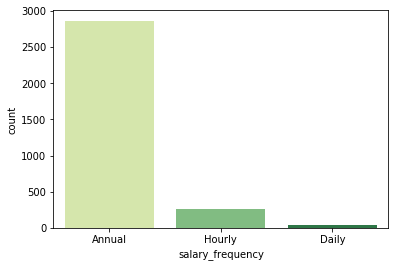

In [0]:
sns.countplot(x='salary_frequency',data=jobs,palette = p2)

Demand Job Categories

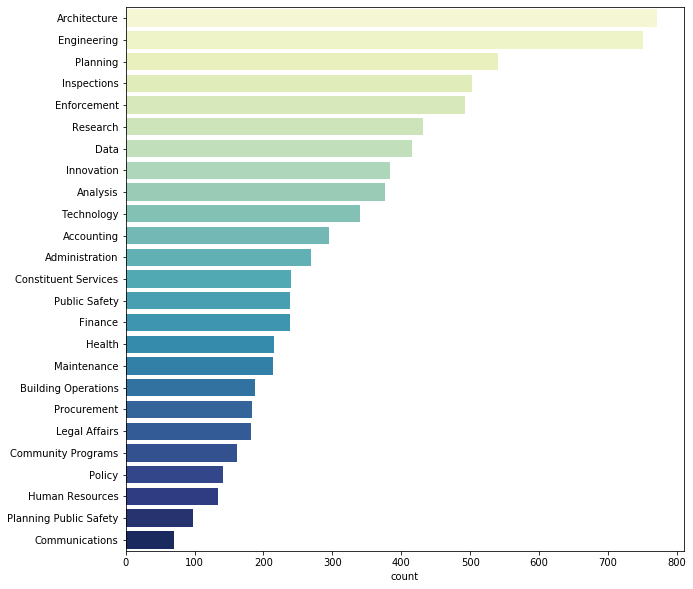

In [0]:
plt.figure(figsize=(10,10))
sns.countplot(y=key_categories, order=popular_categories.index, palette=p)

In [0]:
print(popular_categories.index.tolist())

['Architecture', 'Engineering', 'Planning', 'Inspections', 'Enforcement', 'Research', 'Data', 'Innovation', 'Analysis', 'Technology', 'Accounting', 'Administration', 'Constituent Services', 'Public Safety', 'Finance', 'Health', 'Maintenance', 'Building Operations', 'Procurement', 'Legal Affairs', 'Community Programs', 'Policy', 'Human Resources', 'Planning Public Safety', 'Communications']


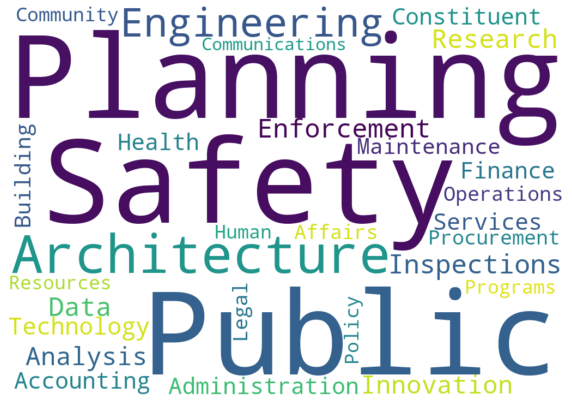

In [0]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(popular_categories.index.tolist()))

Popular Job Titles

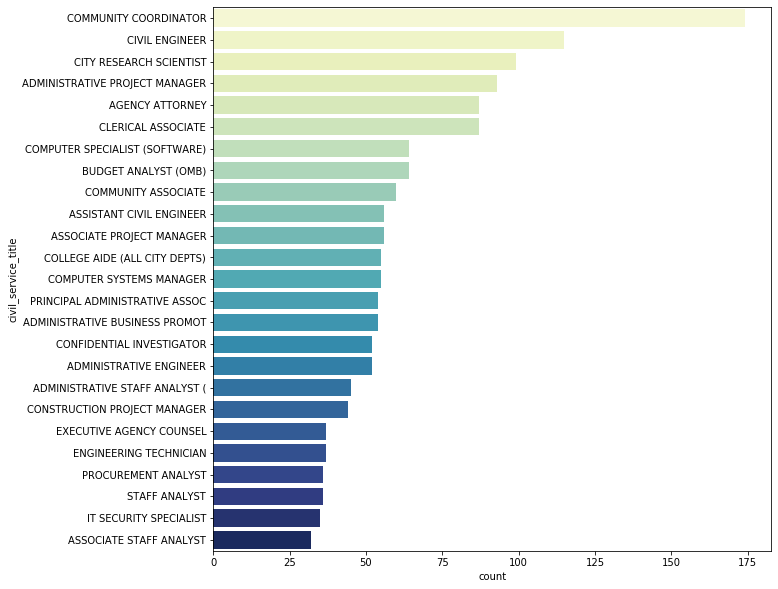

In [0]:
plt.figure(figsize=(10,10))
titles_freq = jobs.civil_service_title.value_counts()
popular_titles = titles_freq.iloc[:25]
sns.countplot(y="civil_service_title", data=jobs, order=popular_titles.index, palette=p)

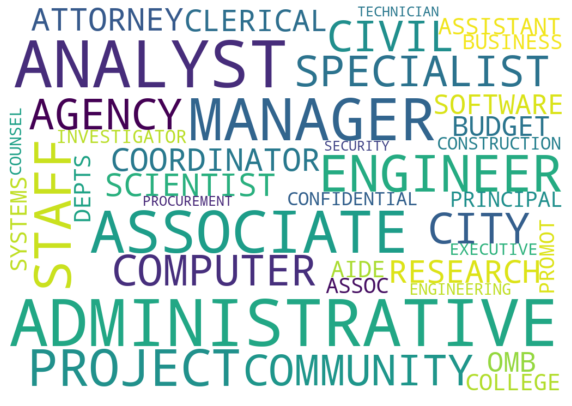

In [0]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(popular_titles.index.tolist()))

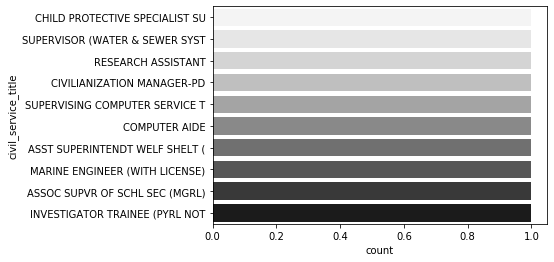

In [0]:
Least_popular = titles_freq.iloc[-10:]
sns.countplot(y="civil_service_title", data=jobs, order=Least_popular.index, palette=p3)

JObs With Highest Low Salary Range

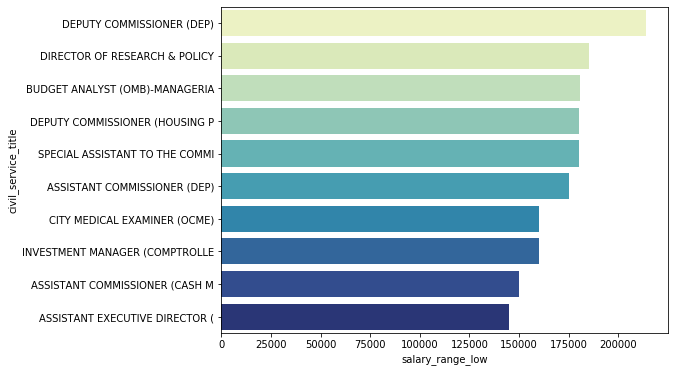

In [0]:
salary_table = jobs[['civil_service_title', 'salary_range_low', 'salary_range_high']]
jobs_highest_low_range = pd.DataFrame(salary_table.groupby(['civil_service_title'])['salary_range_low'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(y='civil_service_title', x='salary_range_low', data=jobs_highest_low_range, palette=p)

JOb with Highest High Salary range

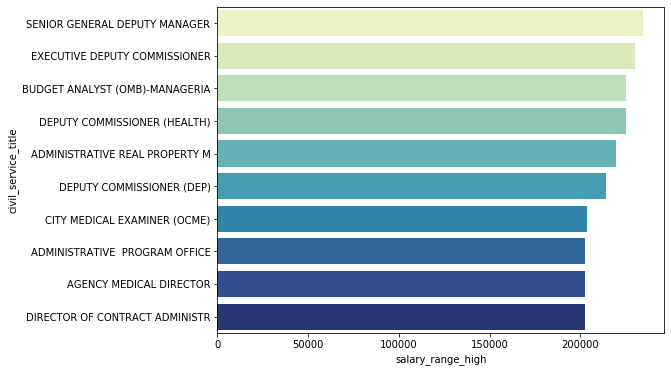

In [0]:
jobs_highest_high_range = pd.DataFrame(salary_table.groupby(['civil_service_title'])['salary_range_high'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(y='civil_service_title', x='salary_range_high', data=jobs_highest_high_range, palette=p)

Highest paying Jobs on Hourly Basis

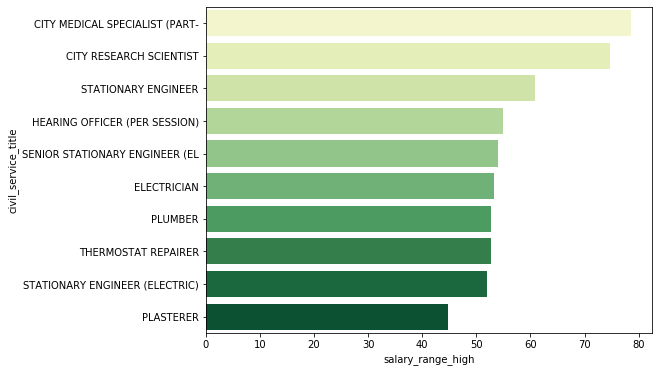

In [0]:
hourly_jobs = jobs[jobs.salary_frequency == 'Hourly']
jobs_highest_high_range_hourly = pd.DataFrame(hourly_jobs.groupby(['civil_service_title'])['salary_range_high'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(y='civil_service_title', x='salary_range_high', data=jobs_highest_high_range_hourly, palette=p2)

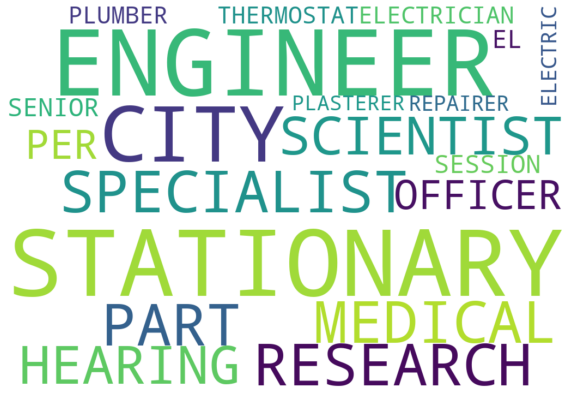

In [0]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(jobs_highest_high_range_hourly['civil_service_title'].tolist()))

Hourly Job Salary DIstribution

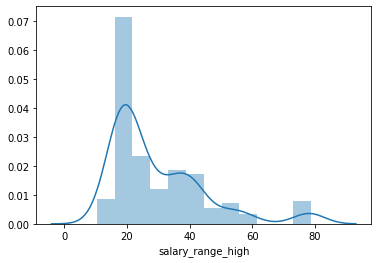

In [0]:
sns.distplot(hourly_jobs.salary_range_high)

Popular Work Units

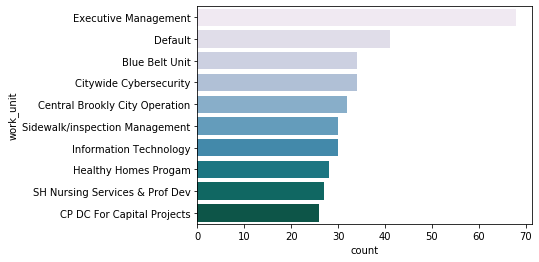

In [0]:
popular_divisions = jobs.work_unit.value_counts().iloc[:10]
sns.countplot(y='work_unit', data=jobs, order=popular_divisions.index, palette='PuBuGn')

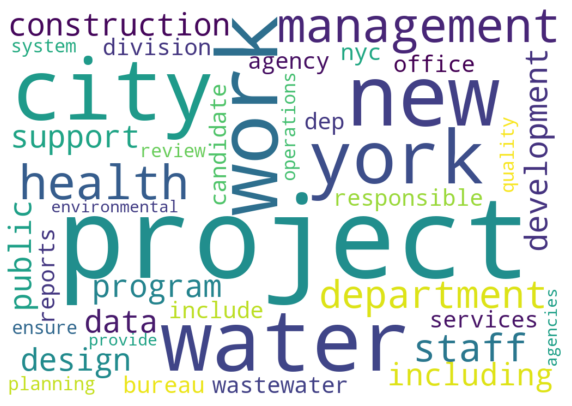

In [0]:
job_description_keywords = []
jobs.job_description.apply(parse_keywords, l=job_description_keywords)
plt.figure(figsize=(10, 8))
counter = Counter(job_description_keywords)
common = [x[0] for x in counter.most_common(40)]
plot_wordcloud(' '.join(common))

Most Preferred Skill on Job Category

In [0]:
opular_categories = jobs.job_category.value_counts()[:5]
popular_categories

Architecture              771
Engineering               750
Planning                  540
Inspections               502
Enforcement               492
Research                  432
Data                      416
Innovation                383
Analysis                  377
Technology                340
Accounting                295
Administration            269
Constituent Services      240
Public Safety             239
Finance                   239
Health                    216
Maintenance               214
Building Operations       188
Procurement               184
Legal Affairs             182
Community Programs        161
Policy                    141
Human Resources           134
Planning Public Safety     98
Communications             70
dtype: int64

Minimum Qualification

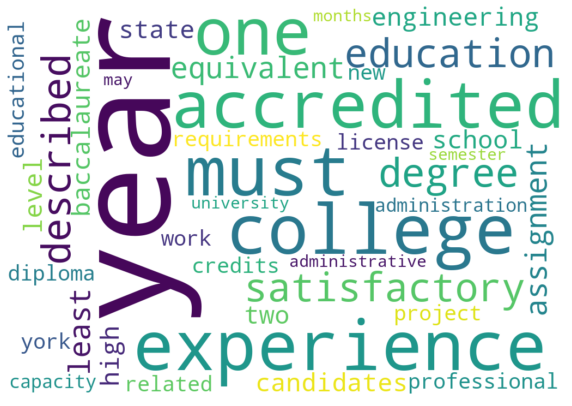

In [0]:
qualification_keywords = []
jobs.minimum_requirements.dropna().apply(parse_keywords, l=qualification_keywords)
plt.figure(figsize=(10, 8))
counter = Counter(qualification_keywords) 
common = [x[0] for x in counter.most_common(40)]
plot_wordcloud(' '.join(common))